### Add these following additional features
---

- [x] data statistics
- [ ] output final df with predictions
- [ ] add score scaler

In [1]:
import sys, os
sys.path.insert(1, "../..")

import pandas as pd
import json

%load_ext autoreload
%autoreload 2

In [92]:
with open("../../config.json","r") as f:
    config = json.load(f)
    
SEED = config["model_params"]["seed"]
TARGET_COL = "target"
INDETERMINATE_COL = config["indeterminate_col"]

In [93]:
from src import train
modeling_df, valid_dfs, test_dfs = train.prep_data(config)

### Code
---

In [94]:
### data statistics

def get_data_statistics(config, modeling_df, 
                        valid_dfs=None, test_dfs=None, 
                        target_col="target", date_col="transaction_datetime",
                        output_json_path=None):
    """
    get df.shape, date_col info, target_col counts
    """
    
    stats = {}
    
    modeling_dfs = {"modeling_df": modeling_df}
    dfs = {}
    for dfs_ in [modeling_dfs, valid_dfs, test_dfs]:
        if dfs_:
            dfs = {**dfs, **dfs_}
    
    for fname, df in dfs.items():
        stats[fname] = {}
        stats[fname][target_col] = df[target_col].value_counts()
        if date_col:
            stats[fname][date_col] = df[date_col].describe()
        
    if output_json_path:
        import json
        stats_ = {}
        for fname, meta in stats.items():
            stats_[fname] = {}
            for col, df in meta.items():
                stats_[fname][col] = df.astype(str).to_dict()
                
        with open(output_json_path, "w") as f:
            json.dump(stats_, f, indent=4)
    return stats
    

In [95]:
get_data_statistics(config, modeling_df, valid_dfs=valid_dfs,
                    output_json_path="statistics.json")

{'modeling_df': {'target': False    108825
  True       3774
  Name: target, dtype: int64,
  'transaction_datetime': count                  112599
  unique                    490
  top       2020-07-20 18:01:31
  freq                      692
  first     2020-05-01 18:01:06
  last      2020-07-30 18:01:11
  Name: transaction_datetime, dtype: object},
 'test_df': {'target': False    243591
  True      13307
  Name: target, dtype: int64,
  'transaction_datetime': count                  256898
  unique                    866
  top       2020-08-10 18:01:13
  freq                     1034
  first     2020-08-03 18:01:06
  last      2020-12-30 18:01:16
  Name: transaction_datetime, dtype: object}}

### Check everything is correct
- [ ] output df have right scores and statistics
- [ ] plots are right
- [ ] performances make sense

In [78]:
modeling_df = pd.read_parquet("s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-01-04/SCORED_modeling_df.parquet")

In [79]:
modeling_df[["pred", "score"]]

,pred,score
6297,0.017570,1.757007
6738,0.044302,4.430153
6743,0.040228,4.022762
6744,0.039678,3.967833
6746,0.039484,3.948361
...,...,...
19400215,0.362113,36.211324
19400253,0.157581,15.758125
19400261,0.210347,21.034682
19400287,0.162670,16.267019


target
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

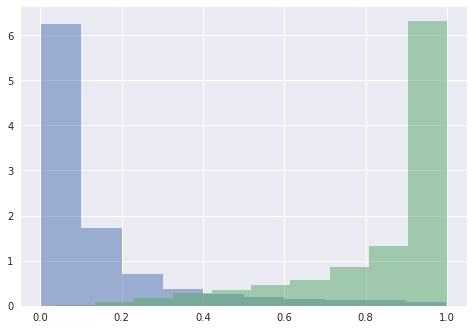

In [86]:
modeling_df[["target", "pred"]].groupby("target")["pred"].hist(alpha=0.5, density=1)

target
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

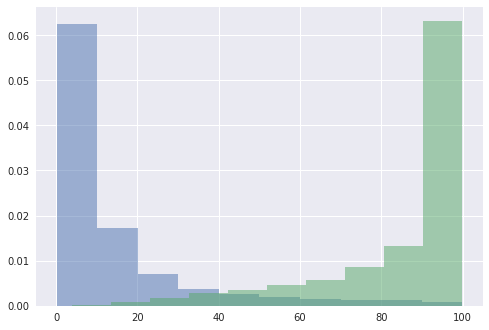

In [85]:
modeling_df[["target", "score"]].groupby("target")["score"].hist(alpha=0.5, density=1)

is_returned
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

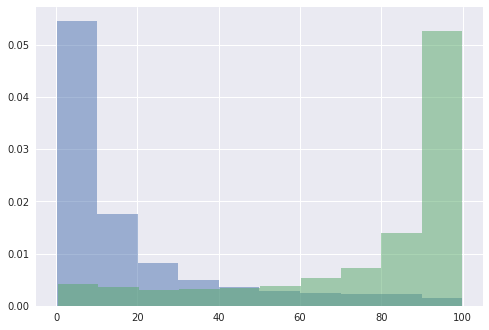

In [88]:
test_df = pd.read_parquet("s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-01-04/SCORED_test_df.parquet")
test_df[["is_returned", "score"]].groupby("is_returned")["score"].hist(alpha=0.5, density=1)

In [89]:
modeling_df.transaction_datetime.describe()

count                  112599
unique                    490
top       2020-07-20 18:01:31
freq                      692
first     2020-05-01 18:01:06
last      2020-07-30 18:01:11
Name: transaction_datetime, dtype: object

In [90]:
test_df.transaction_datetime.describe()

count                  256898
unique                    866
top       2020-08-10 18:01:13
freq                     1034
first     2020-08-03 18:01:06
last      2020-12-30 18:01:16
Name: transaction_datetime, dtype: object